In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

def calculate_roi(model, X_test, y_test, df_original, avg_deposit=5000, profit_margin=0.05, contact_cost=10):
    """Calculate ROI and other business metrics for marketing campaign optimization"""
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results_df = pd.DataFrame({
        'actual': y_test,
        'probability': y_pred_proba
    })
    
    thresholds = np.arange(0.1, 0.9, 0.1)
    roi_metrics = []
    
    for threshold in thresholds:
        results_df['predicted'] = (results_df['probability'] >= threshold).astype(int)
        true_positives = sum((results_df['predicted'] == 1) & (results_df['actual'] == 1))
        false_positives = sum((results_df['predicted'] == 1) & (results_df['actual'] == 0))
        targeted_contacts = sum(results_df['predicted'])
        
        total_contacts = len(y_test)
        baseline_cost = total_contacts * contact_cost
        baseline_conversions = sum(y_test)
        baseline_revenue = baseline_conversions * avg_deposit * profit_margin
        baseline_profit = baseline_revenue - baseline_cost
        baseline_roi = baseline_profit / baseline_cost if baseline_cost > 0 else 0
        
        targeted_cost = targeted_contacts * contact_cost
        targeted_revenue = true_positives * avg_deposit * profit_margin
        targeted_profit = targeted_revenue - targeted_cost
        targeted_roi = targeted_profit / targeted_cost if targeted_cost > 0 else 0
        
        cost_reduction = baseline_cost - targeted_cost
        roi_improvement = targeted_roi - baseline_roi
        
        roi_metrics.append({
            'threshold': threshold,
            'targeted_contacts': targeted_contacts,
            'total_contacts': total_contacts,
            'targeted_percentage': targeted_contacts / total_contacts * 100,
            'true_positives': true_positives,
            'conversion_rate': true_positives / targeted_contacts * 100 if targeted_contacts > 0 else 0,
            'baseline_roi': baseline_roi * 100,
            'targeted_roi': targeted_roi * 100,
            'roi_improvement': roi_improvement * 100,
            'cost_reduction': cost_reduction,
            'profit_improvement': targeted_profit - baseline_profit
        })
    
    roi_df = pd.DataFrame(roi_metrics)
    
    optimal_idx = roi_df['targeted_roi'].idxmax()
    optimal_threshold = roi_df.loc[optimal_idx, 'threshold']
    optimal_roi = roi_df.loc[optimal_idx, 'targeted_roi']
    
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(roi_df['threshold'], roi_df['targeted_roi'], 'b-', marker='o', label='Targeted ROI (%)')
    plt.plot(roi_df['threshold'], roi_df['baseline_roi'], 'r--', label='Baseline ROI (%)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal threshold: {optimal_threshold:.1f}')
    plt.title('ROI Optimization by Threshold')
    plt.xlabel('Probability Threshold')
    plt.ylabel('ROI (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(roi_df['threshold'], roi_df['targeted_percentage'], 'g-', marker='o', label='% Customers Contacted')
    plt.plot(roi_df['threshold'], roi_df['conversion_rate'], 'purple', marker='s', label='Conversion Rate (%)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    optimal_result = roi_df.loc[optimal_idx]
    print(f"\nBusiness Impact Analysis (Optimal Threshold = {optimal_threshold:.2f}):")
    print(f"Contact only {optimal_result['targeted_percentage']:.1f}% of customers")
    print(f"Conversion rate: {optimal_result['conversion_rate']:.2f}%")
    print(f"ROI improvement: {optimal_result['roi_improvement']:.2f}%")
    print(f"Cost reduction: ${optimal_result['cost_reduction']:,.2f}")
    print(f"Profit improvement: ${optimal_result['profit_improvement']:,.2f}")
    
    return roi_df, optimal_threshold


In [9]:
# Model and data
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()
df_test_original = X_test.copy()
df_test_original['y'] = y_test


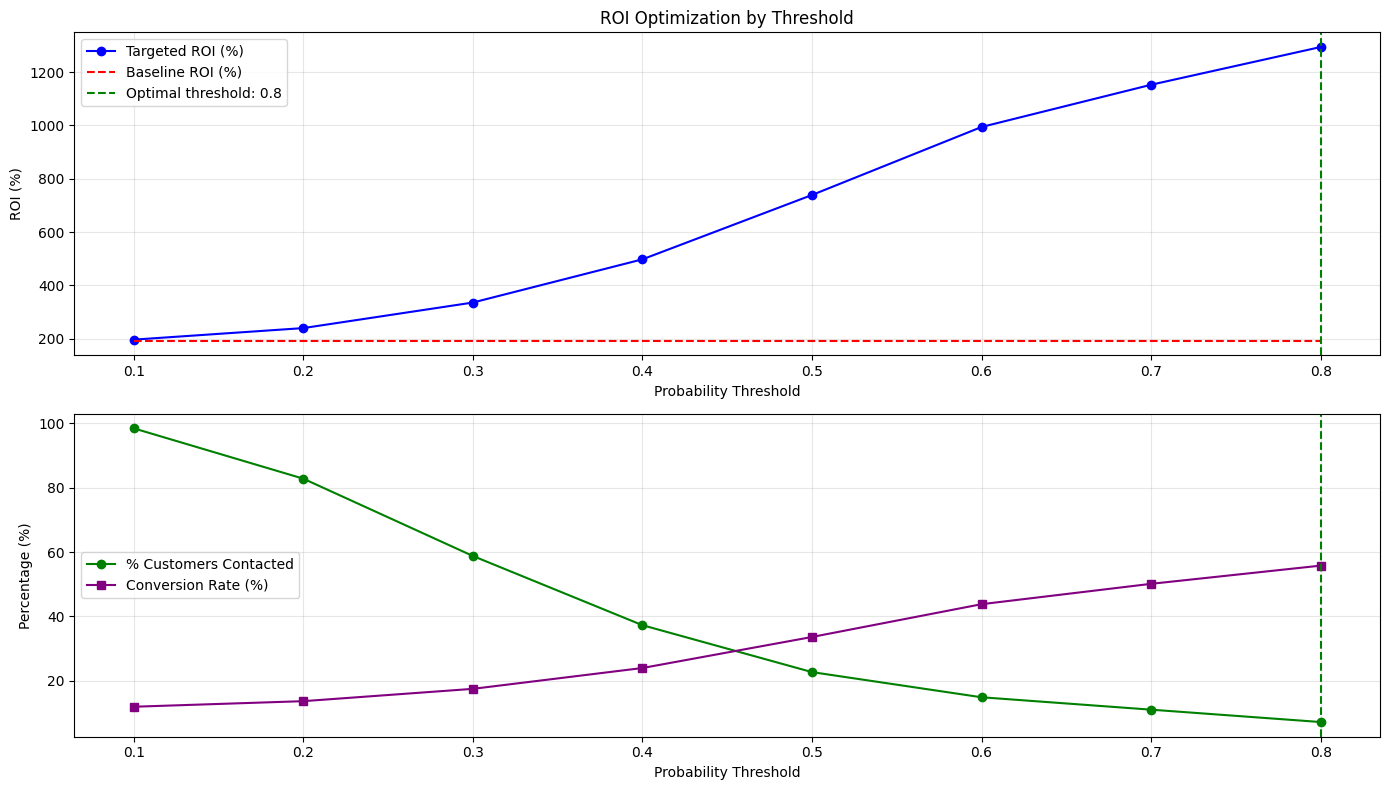


Business Impact Analysis (Optimal Threshold = 0.80):
Contact only 7.1% of customers
Conversion rate: 55.76%
ROI improvement: 1101.59%
Cost reduction: $84,010.00
Profit improvement: $-90,990.00
(8, 11)    threshold  targeted_contacts  total_contacts  targeted_percentage  \
0        0.1               8905            9043            98.473958   
1        0.2               7489            9043            82.815437   
2        0.3               5314            9043            58.763685   
3        0.4               3367            9043            37.233219   
4        0.5               2047            9043            22.636293   
5        0.6               1339            9043            14.807033   
6        0.7                990            9043            10.947694   
7        0.8                642            9043             7.099414   

   true_positives  conversion_rate  baseline_roi  targeted_roi  \
0            1056        11.858506     192.49143    196.462661   
1            1018

In [15]:
best_xgb_model = joblib.load('../models/best_xgb_model.pkl')
roi_df, best_threshold = calculate_roi(
    model=best_xgb_model,
    X_test=X_test,
    y_test=y_test,
    df_original=df_test_original,
    avg_deposit=5000,         # Adjust based on business assumption
    profit_margin=0.05,       # 5% margin
    contact_cost=10           # $10 per outreach
)

print(roi_df.shape, roi_df)


In [11]:
def create_campaign_dashboard(models_dict, roi_results, X_test, y_test, df_original, cluster_df=None):
    """Create comprehensive dashboard for campaign optimization"""
    
    # Extract results and models
    cv_results = models_dict['cv_results']
    best_model = models_dict['best_model']
    
    # 1. MODEL PERFORMANCE COMPARISON
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    model_names = list(cv_results.keys())
    test_scores = [cv_results[name]['test_auc'] for name in model_names]
    cv_scores = [cv_results[name]['cv_score'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, cv_scores, width, label='Cross-Validation AUC', color='skyblue')
    plt.bar(x + width/2, test_scores, width, label='Test AUC', color='coral')
    
    plt.xlabel('Model')
    plt.ylabel('AUC Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add values on top of bars
    for i, v in enumerate(cv_scores):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(test_scores):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. FEATURE IMPORTANCE
    plt.subplot(2, 2, 2)
    
    # Get feature importance from the XGBoost model
    xgb_model = models_dict['base_models']['xgb']
    feature_importances = pd.DataFrame({
        'feature': X_test.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(feature_importances['feature'][::-1], feature_importances['importance'][::-1], color='lightgreen')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance')
    plt.grid(axis='x', alpha=0.3)
    
    # 3. ROI OPTIMIZATION CURVE
    plt.subplot(2, 2, 3)
    
    optimal_threshold = roi_results.iloc[roi_results['targeted_roi'].idxmax()]['threshold']
    
    plt.plot(roi_results['threshold'], roi_results['targeted_roi'], 'b-', marker='o', linewidth=2)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
                label=f'Optimal threshold: {optimal_threshold:.2f}')
    
    plt.xlabel('Probability Threshold')
    plt.ylabel('ROI (%)')
    plt.title('ROI Optimization by Threshold')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # 4. CONVERSION RATE BY CONTACT TYPE/MONTH 
    plt.subplot(2, 2, 4)
    
    # This requires the original dataset with month and contact information
    if 'month' in df_original.columns and 'contact' in df_original.columns:
        pivot = pd.crosstab(
            index=df_original['month'], 
            columns=df_original['contact'],
            values=df_original['y'].map({'yes': 1, 'no': 0}),
            aggfunc='mean'
        ) * 100  # Convert to percentage
        
        pivot.plot(kind='bar', ax=plt.gca())
        plt.title('Conversion Rate by Month and Contact Type')
        plt.xlabel('Month')
        plt.ylabel('Conversion Rate (%)')
        plt.legend(title='Contact Type')
        plt.grid(axis='y', alpha=0.3)
    else:
        # Alternative: show conversion by customer targeting
        best_preds = best_model.predict_proba(X_test)[:, 1]
        deciles = pd.qcut(best_preds, 10, labels=False)
        conversion_by_decile = pd.DataFrame({
            'decile': deciles,
            'actual': y_test
        }).groupby('decile')['actual'].mean() * 100
        
        conversion_by_decile.plot(kind='bar', color='purple')
        plt.title('Conversion Rate by Prediction Decile')
        plt.xlabel('Prediction Decile (Higher = Higher Probability)')
        plt.ylabel('Actual Conversion Rate (%)')
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # 5. CUSTOMER SEGMENTATION DASHBOARD (if available)
    if cluster_df is not None and 'cluster' in cluster_df.columns:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(1, 2, 1)
        cluster_conversion = cluster_df.groupby('cluster')['y'].mean() * 100
        cluster_conversion.plot(kind='bar', color='teal')
        plt.title('Conversion Rate by Customer Segment')
        plt.xlabel('Cluster')
        plt.ylabel('Conversion Rate (%)')
        plt.grid(axis='y', alpha=0.3)
        
        plt.subplot(1, 2, 2)
        # Assuming balance, age, and job are in the dataset
        if 'balance' in cluster_df.columns and 'age' in cluster_df.columns:
            for cluster in cluster_df['cluster'].unique():
                cluster_data = cluster_df[cluster_df['cluster'] == cluster]
                plt.scatter(
                    cluster_data['balance'], 
                    cluster_data['age'],
                    alpha=0.6, 
                    label=f'Cluster {cluster}'
                )
            
            plt.title('Customer Segments by Age and Balance')
            plt.xlabel('Balance')
            plt.ylabel('Age')
            plt.legend()
            plt.grid(alpha=0.3)
        
        plt.tight_layout()
    
    # 6. CAMPAIGN EFFECTIVENESS VISUALIZATION
    plt.figure(figsize=(18, 8))
    
    # Campaign effectiveness by number of contacts
    if 'campaign' in df_original.columns:
        plt.subplot(1, 2, 1)
        campaign_effect = df_original.groupby('campaign')['y'].apply(
            lambda x: (x == 'yes').mean() * 100
        ).reset_index()
        campaign_effect.columns = ['campaign', 'conversion_rate']
        
        # Limit to campaigns with sufficient data
        campaign_counts = df_original['campaign'].value_counts()
        valid_campaigns = campaign_counts[campaign_counts > 50].index
        campaign_effect = campaign_effect[campaign_effect['campaign'].isin(valid_campaigns)]
        
        plt.plot(campaign_effect['campaign'], campaign_effect['conversion_rate'], 
                marker='o', linestyle='-', color='blue')
        plt.title('Conversion Rate by Number of Contacts')
        plt.xlabel('Number of Campaign Contacts')
        plt.ylabel('Conversion Rate (%)')
        plt.grid(alpha=0.3)
    
    # Previous outcome impact
    if 'poutcome' in df_original.columns:
        plt.subplot(1, 2, 2)
        poutcome_effect = df_original.groupby('poutcome')['y'].apply(
            lambda x: (x == 'yes').mean() * 100
        ).reset_index()
        poutcome_effect.columns = ['poutcome', 'conversion_rate']
        
        plt.bar(poutcome_effect['poutcome'], poutcome_effect['conversion_rate'], color='orange')
        plt.title('Conversion Rate by Previous Campaign Outcome')
        plt.xlabel('Previous Outcome')
        plt.ylabel('Conversion Rate (%)')
        plt.grid(axis='y', alpha=0.3)
        
        # Add percentages on top of bars
        for i, v in enumerate(poutcome_effect['conversion_rate']):
            plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 7. PRINT BUSINESS RECOMMENDATIONS
    print("\n===== CAMPAIGN OPTIMIZATION RECOMMENDATIONS =====")
    
    # Best model recommendation
    best_model_name = max(cv_results, key=lambda k: cv_results[k]['test_auc'])
    print(f"✓ Best Predictive Model: {best_model_name} (AUC: {cv_results[best_model_name]['test_auc']:.4f})")
    
    # ROI optimization
    optimal_row = roi_results.iloc[roi_results['targeted_roi'].idxmax()]
    print(f"✓ Optimal Targeting Threshold: {optimal_row['threshold']:.2f}")
    print(f"✓ Contact only {optimal_row['targeted_percentage']:.1f}% of customers")
    print(f"✓ Expected ROI: {optimal_row['targeted_roi']:.2f}% (vs. Baseline ROI: {optimal_row['baseline_roi']:.2f}%)")
    print(f"✓ Projected Cost Reduction: ${optimal_row['cost_reduction']:,.2f}")
    print(f"✓ Projected Profit Improvement: ${optimal_row['profit_improvement']:,.2f}")
    
    return {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'optimal_threshold': optimal_row['threshold'],
        'roi_improvement': optimal_row['roi_improvement']
    }


In [13]:
models_dict = {
    'cv_results': {
        'XGBoost': {'cv_score': 0.801, 'test_auc': 0.803},
        'Random Forest': {'cv_score': 0.787, 'test_auc': 0.788},
        'Stacked Ensemble': {'cv_score': 0.795, 'test_auc': 0.799}
        # Add others if needed
    },
    'best_model': best_xgb_model,
    'base_models': {
        'xgb': best_xgb_model
    }
}

# Ensure this is the DataFrame returned by your `calculate_roi()` function
# Make sure you ran:
# roi_df, best_threshold = calculate_roi(best_xgb_model, X_test, y_test, df_test_original)
roi_results = roi_df

# Also make sure you have:
# - X_test (pandas DataFrame)
# - y_test (Series)
# - df_test_original or df_original (must include columns like 'month', 'contact', 'poutcome')


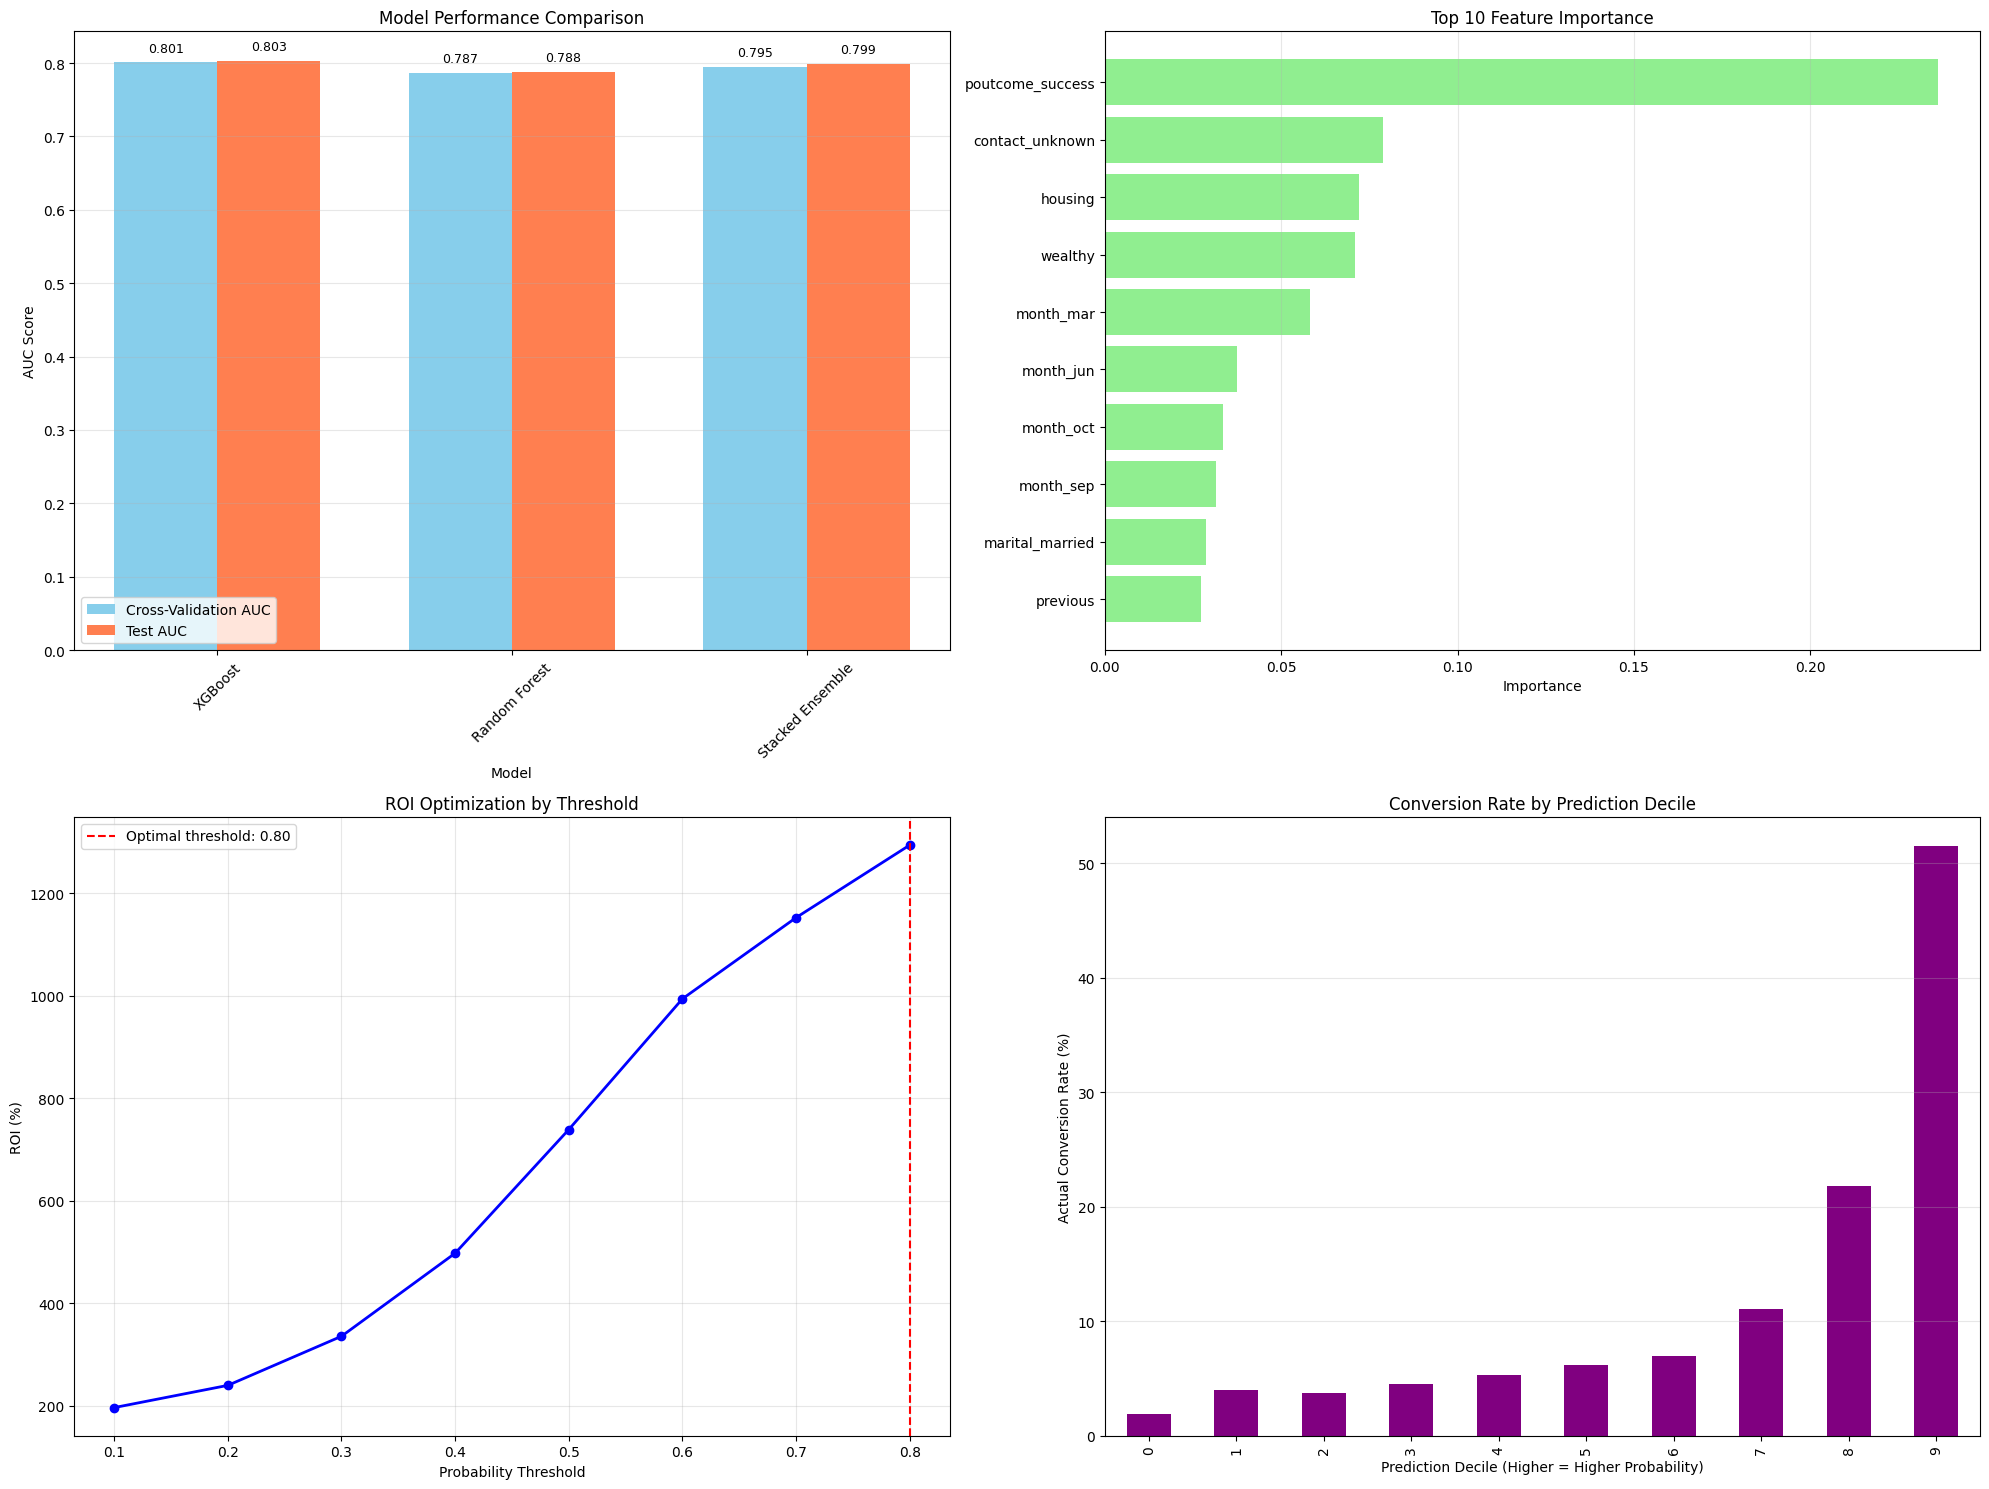

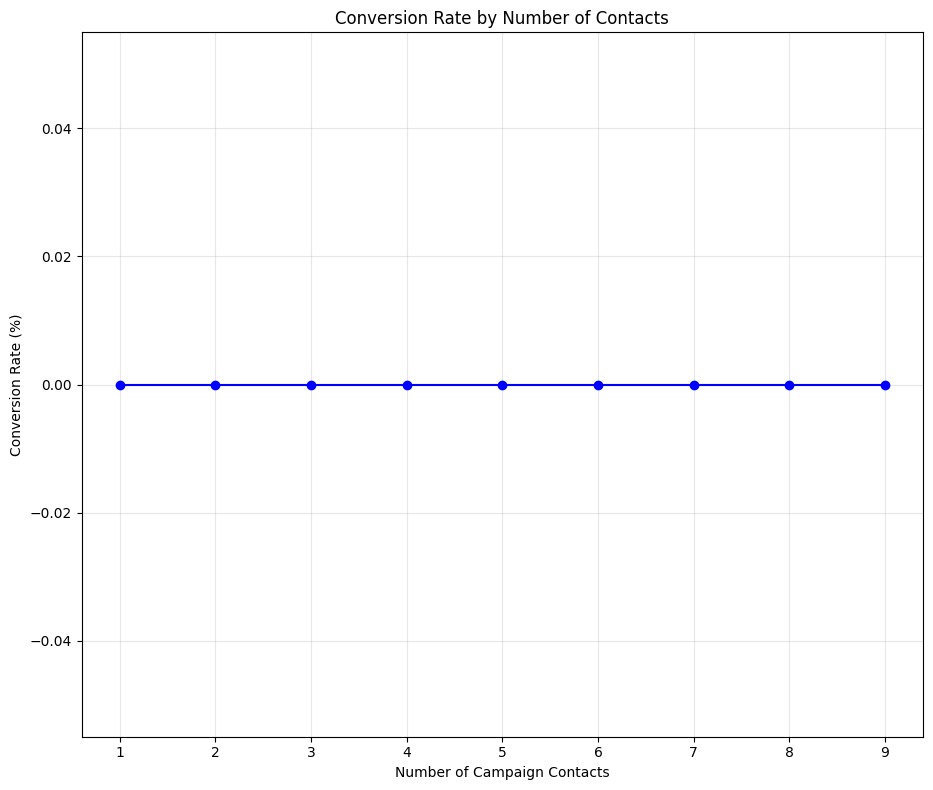


===== CAMPAIGN OPTIMIZATION RECOMMENDATIONS =====
✓ Best Predictive Model: XGBoost (AUC: 0.8030)
✓ Optimal Targeting Threshold: 0.80
✓ Contact only 7.1% of customers
✓ Expected ROI: 1294.08% (vs. Baseline ROI: 192.49%)
✓ Projected Cost Reduction: $84,010.00
✓ Projected Profit Improvement: $-90,990.00


In [14]:
dashboard_outputs = create_campaign_dashboard(
    models_dict=models_dict,
    roi_results=roi_results,
    X_test=X_test,
    y_test=y_test,
    df_original=df_test_original  # or df_original if available
)